In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.mplot3d import Axes3D

In [35]:
def stratify_sample(data, att, n):
    lst_data = []
    unique_att = data[att].unique()
    for each_label in unique_att:
        lst_data.append(data[data[att]==each_label].sample(n=n))
    samples = lst_data[0]
    for each_data in lst_data[1:]:
        samples = pd.concat([samples, each_data])
    return samples

In [2]:
arr = pd.read_feather('clustered_data.feather')

In [3]:
cluster_check = arr[['trip_count', 'tip_amount', 
                     'clean_fare_distance', 'fare_per_minute', 
                     'misc_amount','score_block', 'score_block_kmeans', 
                     'score_block_pca']]

In [144]:
cluster_check

,trip_count,tip_amount,clean_fare_distance,fare_per_minute,misc_amount,score_block,score_block_kmeans,score_block_pca
0,1.0,0.00,5.382422,0.961098,0.00,1,2,1
1,1.0,0.00,2.470896,1.515615,0.09,2,3,1
2,1.0,0.17,5.779702,0.987342,0.05,2,1,1
3,1.0,0.17,3.096418,1.096052,0.01,2,4,1
4,1.0,0.08,3.004514,1.038552,0.00,1,2,1
...,...,...,...,...,...,...,...,...
16078500,1.0,0.17,3.200855,0.780000,0.00,2,4,1
16078501,1.0,0.10,2.658910,1.361851,0.15,2,3,1
16078502,1.0,0.13,2.912095,1.470311,0.09,2,3,1
16078503,1.0,0.20,3.209897,1.071429,0.07,2,1,1


### Cluster Evaluation

In [9]:
class ClusterMetrics:
    
    """
    This metrics is the WSSE/BSSE
    """
    
    def __init__(self, X, y, y_name, scaled = True):
        self.X = X.copy()
        self.y = y
        self.y_name = y_name
        self.clusters = self.y[self.y_name].unique()
    
    def scaler(self):
        scaler = MinMaxScaler()
        self.X[self.X.columns] = scaler.fit_transform(self.X)
    
    def eval_cluster(self):
        
        if self.scaler:
            self.scaler()
        
        cohesion = 0
        separation = 0
        whole_cluster = np.array(np.mean(self.X)).reshape(1, -1)
        
        # iterate each cluster 
        for each_cluster in self.clusters:
            index_y = list(self.y.loc[self.y[self.y_name]==each_cluster, :].index)
            sliced_X = self.X.loc[index_y, :]
            centroid = np.array(np.mean(sliced_X)).reshape(1, -1)
            
            # calculate the distance between each points and centroid only in the cluster
            sliced_X = euclidean_distances(sliced_X, centroid)
            cohesion += sliced_X.sum()
            
            # separation
            n = len(sliced_X)
            separation += euclidean_distances(whole_cluster, centroid)[0][0]*n
            
        return (cohesion, separation, cohesion/separation)

            

Equal Width Binning

In [150]:
# score block manual cluster check
check = ClusterMetrics(cluster_check[cluster_check.columns[:5]],pd.DataFrame(cluster_check[cluster_check.columns[5]]), 'score_block')
res = check.eval_cluster()

print('Result: ')
print('Cohesion:', res[0])
print('Seperation:', res[1])
print('Cohesion/Seperation:', res[-1])

Result: 
Cohesion: 4339630.905556444
Seperation: 1809600.6687008394
Cohesion/Seperation: 2.3981152199020688


K-means

In [151]:
# score block manual cluster check
check = ClusterMetrics(cluster_check[cluster_check.columns[:5]],pd.DataFrame(cluster_check[cluster_check.columns[6]]), 'score_block_kmeans')
res = check.eval_cluster()

print('Result: ')
print('Cohesion:', res[0])
print('Seperation:', res[1])
print('Cohesion/Seperation:', res[-1])

Result: 
Cohesion: 3006309.0041563376
Seperation: 4052307.3350601397
Cohesion/Seperation: 0.7418758636952499


In [64]:
data_res = pd.DataFrame([])
data_res['EWB'] = [4339630.906, 1809600.669, 2.398]
data_res['K-Means'] = [3006309.004, 4052307.335, 0.742]
data_res['Metrics'] = ['Cohesion', 'Seperation', 'Cohesion/Seperation']
data_res.set_index('Metrics')

,EWB,K-Means
Metrics,,
Cohesion,4339630.906,3006309.004
Seperation,1809600.669,4052307.335
Cohesion/Seperation,2.398,0.742


### Cluster Visualisation

Interestingly, the equal width has better seperation compared to k-means, while k-means have better cohesion compared to equal width. Further judgement will be done using visualisation technique of scatter plot

Equal Width Cluster

<Figure size 576x432 with 0 Axes>

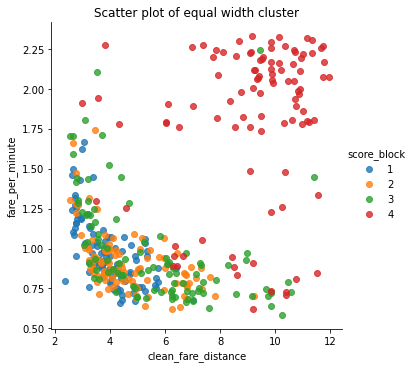

In [249]:
sample = stratify_sample(cluster_check, 'score_block', 100)
plt.figure(figsize=(8, 6))
ax = sns.lmplot(x="clean_fare_distance", y="fare_per_minute",
                data=sample, fit_reg=False, hue='score_block', legend=True)
plt.title('Scatter plot of equal width cluster')
plt.show()

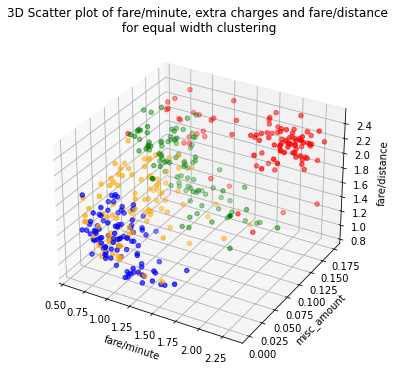

In [252]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('fare/minute')
ax.set_ylabel('misc_amount')
ax.set_zlabel('fare/distance')

colors = {1:'blue', 2:'orange', 3:'green', 4:'red'}

ax.scatter(sample["fare_per_minute"], sample["misc_amount"], np.log(sample["clean_fare_distance"]), 
           c=sample['score_block'].apply(lambda x: colors[x]), marker='o')

# rotate the axes and update
for angle in range(0, -20):
    ax.view_init(5, angle)

plt.title('3D Scatter plot of fare/minute, extra charges and fare/distance\n for equal width clustering')    
plt.show()

K-means Cluster

<Figure size 576x432 with 0 Axes>

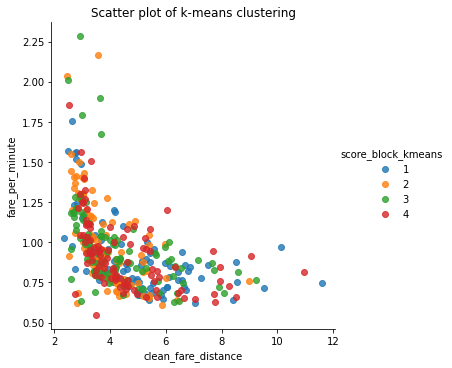

In [253]:
sample = stratify_sample(cluster_check, 'score_block_kmeans', 100)
plt.figure(figsize=(8, 6))
ax = sns.lmplot(x="clean_fare_distance", y="fare_per_minute",
                data=sample, fit_reg=False, hue='score_block_kmeans', legend=True)
plt.title('Scatter plot of k-means clustering')
plt.show()

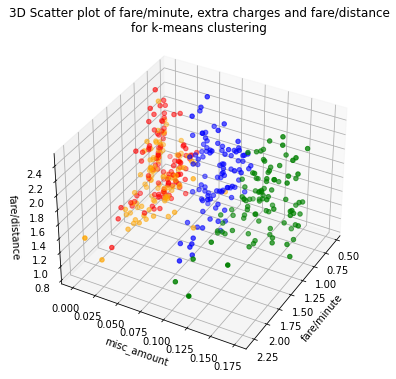

In [254]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('fare/minute')
ax.set_ylabel('misc_amount')
ax.set_zlabel('fare/distance')

colors = {1:'blue', 2:'orange', 3:'green', 4:'red'}

ax.scatter(sample["fare_per_minute"], sample["misc_amount"], np.log(sample["clean_fare_distance"]), 
           c=sample['score_block_kmeans'].apply(lambda x: colors[x]), marker='o')

# rotate the axes and update
for angle in range(0, 30):
    ax.view_init(35, angle)

plt.title('3D Scatter plot of fare/minute, extra charges and fare/distance\nfor k-means clustering')    
plt.show()

Very interesting. It turns out that k-means visually has a good cluster seperation compared to the equal-width cluster. But, k-means cluster were seperated best at misc_amount. In contrast, equal width may have better seperation equally in each attribute by visualisation. Hence, the next step of the research will continue using the equal width labelling, as the seperation give more value for the goal of this project.